In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.signal as signal
from importlib import reload
import lib
import pymaster as nmt

In [2]:
def PT(y, pixels, npix):
    return np.bincount(pixels, y, minlength=npix)

def PTP(pixels, npix):
    return np.bincount(pixels, minlength=npix)

In [3]:
def create_pixels():
    #Hardcoded for nside 128, lol
    row_width = 200 #pixels
    offset = 312
    start = 35000
    nrows = 200
    
    pixels_lr = np.array([np.arange(start+i*(offset+row_width), start+row_width+i*(offset+row_width)) for i in range(nrows)])
    pixels_ud = np.copy(pixels_lr.T)
    
    for pixels in (pixels_lr, pixels_ud):
        pixels[::2] = pixels[::2, ::-1] #flip even rows
        
    return np.concatenate(pixels_lr), np.concatenate(pixels_ud)


In [4]:
ell, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
cl = np.array([TT, TE, EE, BB])
cl /= ell*(ell+1)/2/np.pi 
for c in cl: c[0] = 0

/tmp/ipykernel_20254/2274385076.py:3: RuntimeWarning: invalid value encountered in true_divide
  cl /= ell*(ell+1)/2/np.pi


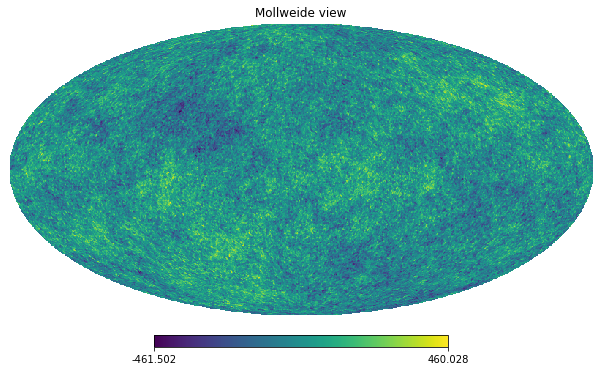

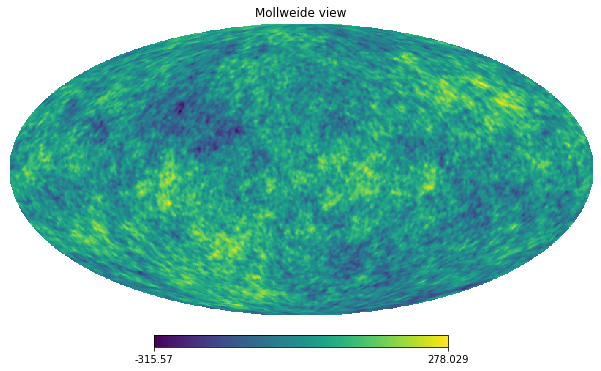

In [5]:
nside = 128
npix = 12*nside**2
lmax = 3*nside-1

m = hp.synfast(cl[0], nside)
m_planck = hp.smoothing(m, sigma=1e-2)

hp.mollview(m)
hp.mollview(m_planck)

In [6]:
pixels_lr, pixels_ud = create_pixels()
nsamp = len(pixels_lr)
rate = 10 #hz
times = np.linspace(0, nsamp/rate, nsamp)

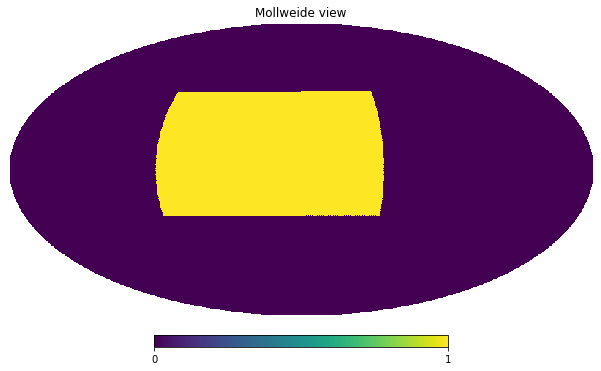

In [7]:
mask = np.zeros(npix)
mask[pixels_lr] = 1
hp.mollview(mask)

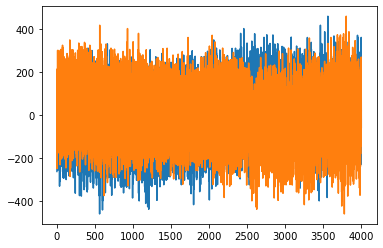

In [8]:
signal_lr = m[pixels_lr]
signal_ud = m[pixels_ud]

plt.plot(times, signal_lr)
plt.plot(times, signal_ud)

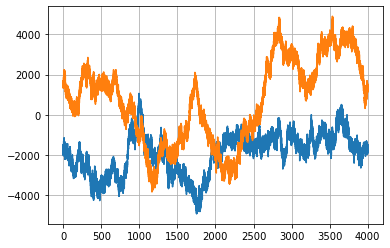

In [9]:
reload(lib)
noise1 = lib.generate_noise(nsamp, 1/rate, fknee=0.5, alpha=2, sigma=100)
noise2 = lib.generate_noise(nsamp, 1/rate, fknee=0.5, alpha=2, sigma=100)

# noise3 = lib.generate_noise(nsamp, 1/rate, fknee=0.5, alpha=2, sigma=100)
# noise4 = lib.generate_noise(nsamp, 1/rate, fknee=0.5, alpha=2, sigma=100)

plt.plot(times, noise1)
plt.plot(times, noise2)
# plt.plot(times, noise3)
# plt.plot(times, noise4)

plt.grid()

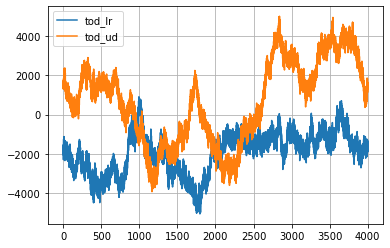

In [10]:
tod_lr_1 = signal_lr + noise1
tod_ud_1 = signal_ud + noise2

# tod_lr_2 = signal_lr + noise3
# tod_ud_2 = signal_ud + noise4

plt.plot(times, tod_lr_1, label='tod_lr')
plt.plot(times, tod_ud_1, label='tod_ud')
plt.legend()
plt.grid()

In [11]:
def subscan_polyfilter(times, tod, n_sub=200, deg=3):
    subscans = np.array_split(np.copy(tod), n_sub)
    subscans_times = np.array_split(times, n_sub)
    for time, scan in zip(subscans_times, subscans):
        poly = np.polynomial.polynomial.Polynomial.fit(time, scan, deg)
        scan -= poly(time)
    return np.concatenate(subscans)

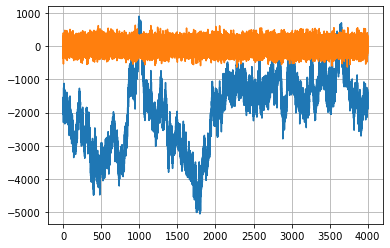

In [12]:
filtered_tod_lr_1 = subscan_polyfilter(times, tod_lr_1)
filtered_tod_ud_1 = subscan_polyfilter(times, tod_ud_1)

# filtered_tod_lr_2 = subscan_polyfilter(times, tod_lr_2)
# filtered_tod_ud_2 = subscan_polyfilter(times, tod_ud_2)

plt.plot(times, tod_lr_1)
plt.plot(times, filtered_tod_lr_1)
plt.grid()

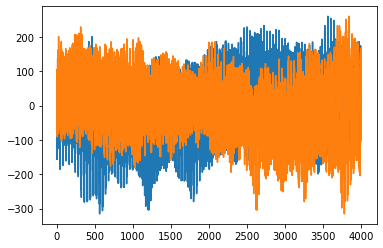

In [13]:
#Replace lost power
planck_tod_lr = m_planck[pixels_lr]
planck_tod_ud = m_planck[pixels_ud]

plt.plot(times, planck_tod_lr)
plt.plot(times, planck_tod_ud)


In [14]:
filtered_planck_tod_lr = subscan_polyfilter(times, planck_tod_lr)
filtered_planck_tod_ud = subscan_polyfilter(times, planck_tod_ud)

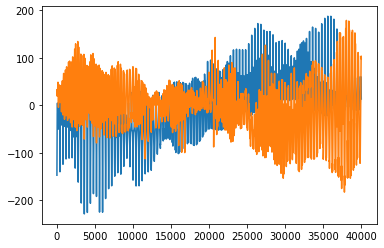

In [15]:
signal_lost_lr = planck_tod_lr - filtered_planck_tod_lr
signal_lost_ud = planck_tod_ud - filtered_planck_tod_ud

plt.plot(signal_lost_lr)
plt.plot(signal_lost_ud)

In [16]:
#Add signal back
replaced_tod_lr = filtered_tod_lr_1 + signal_lost_lr
replaced_tod_ud = filtered_tod_ud_1 + signal_lost_ud

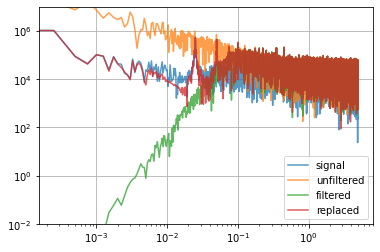

In [17]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_unfiltered = np.fft.rfft(tod_lr_1)
fft_filtered = np.fft.rfft(filtered_tod_lr_1)
fft_signal = np.fft.rfft(signal_lr)
fft_noise = np.fft.rfft(noise1)
fft_replaced = np.fft.rfft(replaced_tod_lr)

plt.loglog(freqs, np.abs(fft_signal), label='signal', alpha=0.75)
# plt.plot(freqs, np.abs(fft_noise), label='noise', alpha=0.75)
plt.plot(freqs, np.abs(fft_unfiltered), label='unfiltered', alpha=0.75)
plt.plot(freqs, np.abs(fft_filtered), label='filtered', alpha=0.75)
plt.plot(freqs, np.abs(fft_replaced), label='replaced', alpha=0.75)
plt.legend()
plt.ylim([1e-2,1e7])
plt.grid()

In [18]:
def bin_map(tod_list, pixels_list, npix):
    assert len(tod_list) == len(pixels_list)
    
    noise_weighted_map = np.zeros(npix)
    npp = np.zeros(npix)
    
    for tod, pixels in zip(tod_list, pixels_list):
        noise_weighted_map += PT(tod, pixels, npix)
        npp += PTP(pixels, npix)
    
    return noise_weighted_map / npp

In [19]:
# m_bin =  bin_map([tod_lr_1, tod_lr_2, tod_ud_1, tod_ud_2], [pixels_lr, pixels_lr, pixels_ud, pixels_ud], npix)

m_filterbin_1 = bin_map([filtered_tod_lr_1, filtered_tod_ud_1], [pixels_lr, pixels_ud], npix)
# m_filterbin_2 = bin_map([filtered_tod_lr_2, filtered_tod_ud_2], [pixels_lr, pixels_ud], npix)

m_replaced = bin_map([replaced_tod_lr, replaced_tod_ud], [pixels_lr, pixels_ud], npix)

# m_lr = bin_map([filtered_tod_lr], [pixels_lr], npix)
# m_ud = bin_map([filtered_tod_ud], [pixels_ud], npix)

/tmp/ipykernel_20254/2076122746.py:11: RuntimeWarning: invalid value encountered in true_divide
  return noise_weighted_map / npp


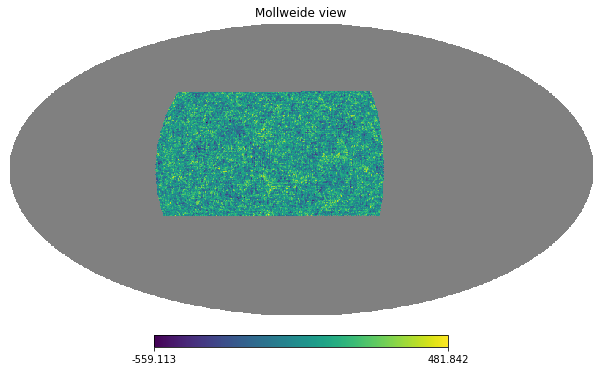

In [20]:
hp.mollview(m_filterbin_1)

In [21]:
# hp.mollview(m_filterbin_2)

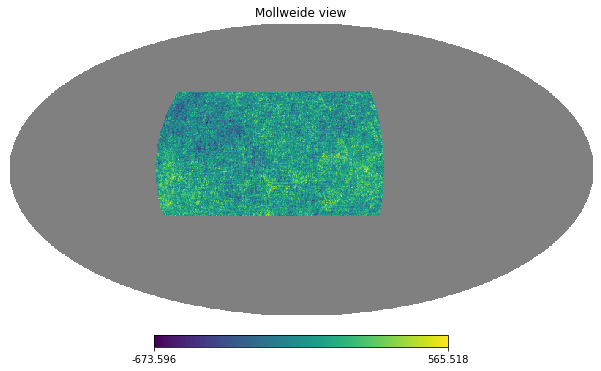

In [22]:
hp.mollview(m_replaced)

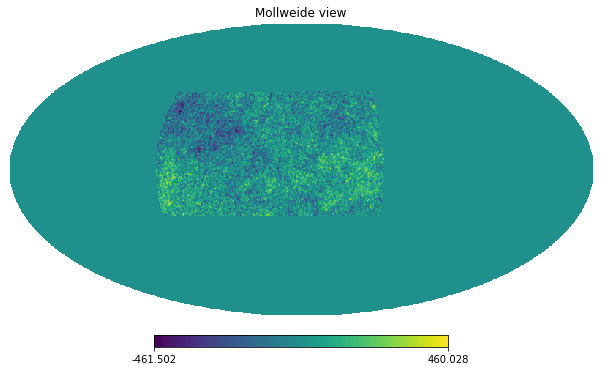

In [23]:
hp.mollview(mask * m)

In [24]:
m_filterbin_1[np.isnan(m_filterbin_1)] = 0
# m_filterbin_2[np.isnan(m_filterbin_2)] = 0
# m_bin[np.isnan(m_bin)] = 0
m_replaced[np.isnan(m_replaced)] = 0

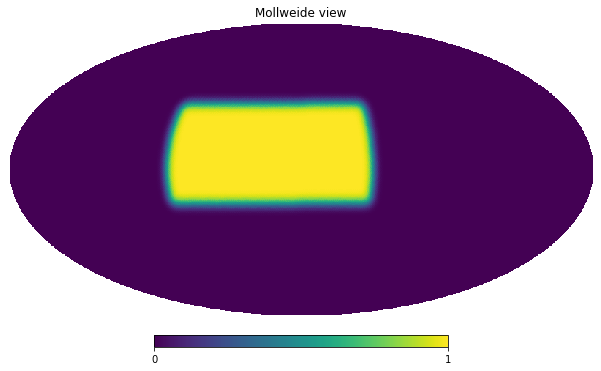

In [25]:
mask_apo = nmt.mask_apodization(mask, 2.5, apotype="Smooth")
hp.mollview(mask_apo)

In [26]:
f_1 = nmt.NmtField(mask_apo, [m_filterbin_1])
# f_2 = nmt.NmtField(mask_apo, [m_filterbin_2])
# f_bin = nmt.NmtField(mask_apo, [m_bin])
f_in = nmt.NmtField(mask_apo, [m])
f_replaced = nmt.NmtField(mask_apo, [m_replaced])

In [27]:
b = nmt.NmtBin.from_nside_linear(nside, 4)

In [28]:
cl_1 = nmt.compute_full_master(f_1, f_1, b)
# cl_2 = nmt.compute_full_master(f_2, f_2, b)
# cl_12 = nmt.compute_full_master(f_1, f_2, b)
cl_input = nmt.compute_full_master(f_in, f_in, b)
# cl_bin = nmt.compute_full_master(f_bin, f_bin, b)
cl_replaced = nmt.compute_full_master(f_replaced, f_replaced, b)

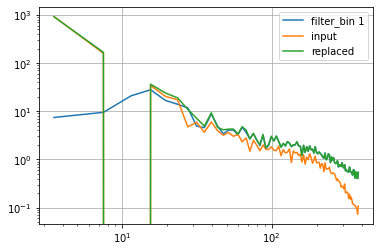

In [29]:
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_1[0], label='filter_bin 1')
# plt.plot(ell_arr, cl_2[0], label='filter_bin 2')
# plt.plot(ell_arr, cl_12[0], label='cross')
plt.loglog(ell_arr, cl_input[0], label='input')
# plt.plot(ell_arr, cl_bin[0], label='bin')
plt.plot(ell_arr, cl_replaced[0], label='replaced')

plt.grid()
plt.legend()